In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [4]:
print(len(train_labels))

60000


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

train_labels = train_labels.astype('float32')
train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = test_labels.astype('float32')
test_labels = tf.keras.utils.to_categorical(test_labels,10)


print('train images shape is : ', np.shape(train_images))
print('train labels shape is : ', np.shape(train_labels))

train images shape is :  (60000, 28, 28, 1)
train labels shape is :  (60000, 10)


In [6]:
TRAIN_BUF = 60000 #same as image_size
BATCH_SIZE = 100
IMAGE_SIZE = 28
TEST_BUF = 10000

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [8]:
class CVAE(tf.keras.Model): #Inherit keras model class 
    def __init__(self, latent_dim, class_dim):
        super(CVAE, self).__init__() #init keras model class, then can use keras model function here without prob.
        self.latent_dim = latent_dim
        self.class_dim = class_dim
        self.generative_model = self.generative_net()
        self.inference_model = self.inference_net()
        
    def inference_net(self):
        x_in = tf.keras.layers.Input(shape=[IMAGE_SIZE,IMAGE_SIZE,1])
        cond_in=tf.keras.layers.Input(shape=[10,])
        
        cond = tf.keras.layers.Reshape(target_shape=(1,1,10))(cond_in)
        
        cond_merge = tf.keras.layers.Lambda(tf.keras.backend.tile, arguments={'n':(1,IMAGE_SIZE,IMAGE_SIZE,1)})(cond)
        concat = tf.keras.layers.Concatenate()
        x_c = concat([x_in,cond_merge])
        
        conv1 = tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2,2), activation='relu')(x_c)
        conv2 = tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2,2), activation='relu')(conv1)
        flat_layer = tf.keras.layers.Flatten()(conv2)
        inference_out = tf.keras.layers.Dense(latent_dim+latent_dim)(flat_layer) #mu and sigma
        
        
        return tf.keras.Model(inputs=[x_in,cond_in], outputs=inference_out)
    
    
    def generative_net(self):
        
        z_in = tf.keras.layers.Input(shape=[latent_dim,])
        z = tf.keras.layers.Dense(7*7*32, activation=tf.nn.relu)(z_in)
        z = tf.keras.layers.Reshape(target_shape=(7,7,32))(z)
        
        cond_in = tf.keras.layers.Input(shape=[10,])
        cond = tf.keras.layers.Reshape(target_shape=(1,1,10))(cond_in)
        cond_tile = tf.keras.layers.Lambda(tf.keras.backend.tile, arguments={'n':(1,7,7,1)})(cond)
        
        Concat = tf.keras.layers.Concatenate()
        z_c = Concat([z, cond_tile])
         
        convt1 = tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=(2,2),padding="SAME",activation='relu')(z_c)
        convt2 = tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=(2,2), padding="SAME", activation='relu')(convt1)
        out = tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1,1), padding="SAME")(convt2)
       
        return tf.keras.Model(inputs=[z_in,cond_in], outputs=out)
        
    @tf.function
    def sample(self, cond, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(BATCH_SIZE,self.latent_dim))
        return self.decode(eps, cond, apply_sigmoid=True)

    def encode(self, x, cond):
        mean, logvar = tf.split(self.inference_model([x,cond]), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps*tf.exp(logvar * .5)+mean

    
    def decode(self,z,cond,apply_sigmoid=False):
        logits = self.generative_model([z, cond])

        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            
            return probs

        return logits
        

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-3, beta_1=0.0, beta_2 = 0.99)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.*np.pi)
    return tf.reduce_sum(-.5*((sample-mean)**2. * tf.exp(-logvar)+ logvar + log2pi), axis=raxis)

@tf.function
def compute_loss(model,x, cond):
    
    #build model
    mean, logvar = model.encode(x, cond)
    z = model.reparameterize(mean, logvar)  
    x_logit = model.decode(z, cond)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    return -tf.reduce_mean(logpx_z +logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, cond, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, cond)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [10]:
epochs = 100
latent_dim = 50
class_dim = 10

num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape = [num_examples_to_generate, latent_dim])
random_vector_labels = np.asarray([0,1,2,3,4,5,6,7,8,9,8,7,6,5,4,3]).astype(float)
random_vector_labels = tf.keras.utils.to_categorical(random_vector_labels,10)

model = CVAE(latent_dim,class_dim)


In [11]:
def generate_and_save_images(model, epoch, test_input, test_cond):
    
    predictions = model.sample(test_cond, test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('./test_img/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


Epoch: 100, Test set ELBO: -93.2023696899414, time elapse for current epoch 3.6555020809173584


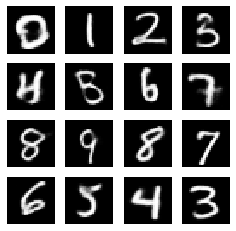

In [12]:
generate_and_save_images(model, 0, random_vector_for_generation, random_vector_labels)
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for (train_x, train_labels) in train_dataset:
        
        compute_apply_gradients(model, train_x, train_labels, optimizer)
        end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for (test_x, test_labels) in test_dataset:
            
            loss(compute_loss(model, test_x, test_labels))
            
            
        elbo = -loss.result()
        
        display.clear_output(wait=True)  
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))
        
        generate_and_save_images(model, epoch, random_vector_for_generation, random_vector_labels)

In [13]:
anim_file = './test_img/cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./test_img/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)
        
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)